In [1276]:
# import os
# import tensorflow as tf
# print(tf.device('/gpu:0'))
# os.environ['CUDA_VISIBLE_DEVICES'] = "0"

In [1277]:
#导包
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import math
import time

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# from numba import jit
# @jit(nopython==True)

In [1278]:
#导入方法
from SimilitudItems import *

In [1279]:
start = time.time()

In [1280]:
#初始化一些参数
K1 = 3
K2 = -10
alpha = 0.95#两个K和alpha在处理打分矩阵时候用到
Ucluster_number = 3#输出聚类结果的前三个
iter_num = 100#y的行数

In [1281]:
#初始化参数
mycase = 1   # 读取哪个数据集
neibor_num = 40  # 邻居数

In [1282]:
#读取数据
# 读训练集
if mycase == 1:
    u = pd.read_csv("features.csv")
    # print(u)
    # for i in range(len(u)):
    #     if (u.loc[i,"score"]<100.0):
    #         u.loc[i,"score"] = 10.0
    #     elif (100.0<u.loc[i,"score"]<1000.0):
    #         u.loc[i,"score"] = 20.0
    #     elif (1000.0<u.loc[i, "score"] < 10000.0):
    #         u.loc[i, "score"] = 30.0
    #     elif (10000.0<u.loc[i, "score"] < 100000.0):
    #         u.loc[i, "score"] = 40.0
    # print(u)
    u1 = u.iloc[:6400,:]
    uf = u.iloc[6400:,:]
    # print(uf)
    # u1 = pd.read_csv("u1base.csv")
elif mycase == 2:
    u1 = pd.read_csv("u2base.csv")
elif mycase == 3:
    u1 = pd.read_csv("u3base.csv")
elif mycase == 4:
    u1 = pd.read_csv("u4base.csv")
elif mycase == 5:
    u1 = pd.read_csv("u5base.csv")

In [1283]:
#查看大小
# print(u1.shape[0])
m = u1.shape[0]  # 训练集评分行为数量
print(m)

6400


In [1284]:
#把csv表转化为矩阵  横坐标用户id，纵坐标电源id，值为评分
# 建立评分矩阵
number_user = int(max(u1["user_id"])) # 获取用户数量，为943
number_movies = int(max(u1["item_id"])) # 获取电影数量，为1682
N = number_user + number_movies # N = 用户数量 + 电影数量 = 2625
# print(type(number_movies),number_user,N)
score_matrix = np.zeros([number_user, number_movies])

In [1285]:
#对矩阵元素进行赋值
for i in range(0, m):
    score_matrix[int(u1["user_id"][i]-1)][int(u1["item_id"][i]-1)] = u1["score"][i] # 填评分矩阵
    # 由于下标从0开始，所以用户id和电影id需要-1

In [1286]:
#把评分矩阵放入另一个矩阵
# score_matrix = np.pad(score_matrix, ((0,1682) , (943,0)), mode = 'constant', constant_values=(0, 0))
adj_matrix = np.zeros((N, N))
adj_matrix[0 : number_user, number_user : N] = score_matrix  # 异质网络右上角：评分矩阵
adj_matrix += adj_matrix.T  # 异质网络左下角：评分矩阵转置
print(adj_matrix)

[[0.    0.    0.    ... 0.    0.    0.   ]
 [0.    0.    0.    ... 0.    0.    1.   ]
 [0.    0.    0.    ... 3.742 0.    4.537]
 ...
 [0.    0.    3.742 ... 0.    0.    0.   ]
 [0.    0.    0.    ... 0.    0.    0.   ]
 [0.    1.    4.537 ... 0.    0.    0.   ]]


In [1287]:
#再建一个矩阵，第一行赋予任意值
y = np.zeros((iter_num, N)) # y规模为 iter * 2625
y[0, :] = np.random.rand(N) * math.pi/2 # y第一行所有值都处于[0, pi/2]之间

In [1288]:
#利用上面得到的打分矩阵（包含原矩阵&转置的那个）进行计算
print("e =", end=" ")
count = 0
for e in range(0, iter_num - 1):
    print(e, end=" ")
    for i in range(0, N):
        a = 0
        b = 0
        # 找出adj_matrix里面满足要求的数据进行计算，结果放到y里面
        # ---------------------------------
        bigger_3 = np.where(adj_matrix[i, :] >= 10)  # 评分大于等于3，认为对项目感兴趣
        a = a + sum(math.sin(x) for x in np.multiply(adj_matrix[i, bigger_3], (y[e, bigger_3] - y[e, i])).tolist()[0])

        smaller_3 = np.where((adj_matrix[i, :] < 10) & (adj_matrix[i, :] >= 1))  # 评分小于3，认为对项目不感兴趣
        b = b + sum(math.sin(x) for x in np.multiply(adj_matrix[i, smaller_3], (y[e, smaller_3] - y[e, i])).tolist()[0])
        # # ---------------------------------#
        # bigger_3 = np.where(adj_matrix[i, :] >= 80)  # 评分大于等于3，认为对项目感兴趣
        # a = a + sum(math.sin(x) for x in np.multiply(adj_matrix[i, bigger_3], (y[e, bigger_3] - y[e, i])).tolist()[0])
        #
        # smaller_3 = np.where((adj_matrix[i, :] < 80) & (adj_matrix[i, :] >= 1))  # 评分小于3，认为对项目不感兴趣
        # b = b + sum(math.sin(x) for x in np.multiply(adj_matrix[i, smaller_3], (y[e, smaller_3] - y[e, i])).tolist()[0])

    #用分数矩阵和y矩阵的第e行，算第e+1行
        y[e + 1, i] = alpha * y[e, i]- 0.05 * y[e, i]* y[e, i]  + (K1 / N * a + K2 / N * b)
        
    if np.linalg.norm(y[e + 1, :] - y[e, i]) < 1e-3:  # 矩阵y第e+1行所有值都减去y(e,i)
        break
    count = e + 1

e = 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 

In [1289]:
#画图看一下上面的处理结果
temp_x = range(0, iter_num - 2)  # 作图x轴取值
temp_y = y[1:e+1, :]  # 作图y轴取值

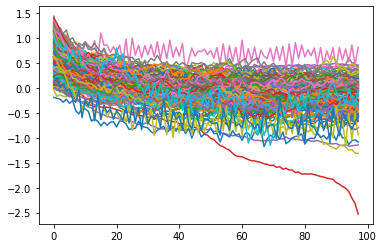

In [1290]:
#画图看一下
plt.plot(temp_x, temp_y)
plt.show()

In [1291]:
#k均值聚类
a = KMeans(n_clusters=3).fit(y[count-2: count-1, 0: number_user].T)  # 聚类
print(a)

KMeans(n_clusters=3)


In [1292]:
#看前3个聚类结果
b = a.labels_ # 观察聚类结果
for i in range(0, Ucluster_number):
    print('%d:'% i, sum(b == i))
type(b)

0: 167
1: 43
2: 1


numpy.ndarray

In [1293]:
index = [0]*Ucluster_number
sim_matrix = [0]*Ucluster_number

In [1294]:
#这是干了个啥:好像是做什么相似化处理
for i in range(0, Ucluster_number):
    temp = np.where(b[:] == i)
    data = score_matrix[temp, :]
    index[i] = temp
    sim_matrix[i] = SimilitudItems(data[0].T, 'cosine')

In [1295]:
# data = score_matrix[temp, :]
# data[0].shape

In [1296]:
# 读测试集，预测开始
if mycase == 1:
    # u2 = uf
    u2 = pd.read_csv("features_Random.csv")
    # print(u2)
    # u2 = pd.concat([uf,u2],axis=0,ignore_index=True)
    # u2 = u2.iloc[0:1000,:]
    # print(u2)
    # u2 = uf
    # u2=pd.concat([u2,uf],axis=0)
    # u2 = pd.read_csv("u1test.csv")
elif mycase == 2:
    u2 = pd.read_csv("u2test.csv")
elif mycase == 3:
    u2 = pd.read_csv("u3test.csv")
elif mycase == 4:
    u2 = pd.read_csv("u4test.csv")
elif mycase == 5:
    u2 = pd.read_csv("u5test.csv")

In [1297]:
# u2 = u2[:6437]
pp = np.where(u2["item_id"] > max(u1["item_id"]))  # 出现在测试集中，但没有出现在训练集中的项目
print(u2)

     user_id  item_id     score  time
0          1       33   276.255   NaN
1          1       69   217.024   NaN
2          1       55  1014.636   NaN
3          1       35   173.076   NaN
4          1       29   442.639   NaN
..       ...      ...       ...   ...
995      208       88    14.969   NaN
996      209       88     7.484   NaN
997      210       80    12.972   NaN
998      210       71   308.032   NaN
999      211        6    39.920   NaN

[1000 rows x 4 columns]


In [1298]:
m = u2.shape[0]
Predict_score = np.zeros((m, 1))  # 预测分数矩阵，规模为20000 * 1

In [1299]:
m

1000

In [1300]:
i = 2
print(i, end=" ")
user = u2["user_id"][i]  # 获取测试集中第i个用户的id
item = u2["item_id"][i]  # 获取测试集中第i个电影的id
no2 = b[user-1]  # no2表示id为user的这个用户属于哪一个社区
user1 = np.where(index[no2][0] == user-1)
# 以下是计算基于用户的协同过滤
up_score_matrix = score_matrix[index[no2][0]]  # 获取同社区的用户评分矩阵

2 

In [1301]:
up_score_matrix.shape

(43, 90)

In [1302]:
for i in range(0, 1000):
    if i % 1000 == 0:
        print(i/1000, 'k', end=" ")
    user = u2["user_id"][i]  # 获取测试集中第i个用户的id
    item = u2["item_id"][i]  # 获取测试集中第i个电影的id
    no2 = b[user-1]  # no2表示id为user的这个用户属于哪一个社区
    user1 = np.where(index[no2][0] == user-1)
    # 以下是计算基于用户的协同过滤
    up_score_matrix = score_matrix[index[no2][0]] # 获取同社区的用户评分矩阵
    # BB = np.where(up_score_matrix[user1[0][0],:] != 0)  # 与user处于同社区的评分矩阵中第user1个用户已评分的电影id
    BB = np.where(up_score_matrix[user1[0][0],:] != -1)
    aver_score = np.mean(up_score_matrix[user1[0][0], BB],1)  # 该用户对已评分项目的平均值
    P_u = np.where(up_score_matrix[:,item-1] != 0)
    # P_u = np.where(int(up_score_matrix[:,item-1]) != 0)  # P_u记录与user处于同社区，看过id=item电影的用户在该社区的索引
    if len(P_u) == 0:
        i = 0
        Predict_score[i] = round(aver_score[0])
    else:
        P_u_sim = sim_matrix[no2][user1[0][0]][P_u[0]]  # 计算待评价用户与已评价用户的相似度
        s = pd.Series(P_u_sim).sort_values(ascending = False)[:]
        index1 = s.index.tolist()
        num1 = len(index1)
        if num1 >= neibor_num: # 如果index1记录的id比neibor_num还多，只要前neibor_num个
            neibor = [0 for i in range(neibor_num)]
            a_score = [0 for i in range(neibor_num)]
            for k in range(0, neibor_num):
                neibor[k] = P_u[0][index1[k]]
        else:
            neibor = [0 for i in range(num1)]
            a_score = [0 for i in range(num1)]
            for k in range(0, num1):
                neibor[k] = P_u[0][index1[k]]
        sum1 = 0
        sum2 = 0
        for j in range(0, len(neibor)):
            BB = np.where(up_score_matrix[neibor[j], :] != 0)
            a_score[j] = np.mean(up_score_matrix[neibor[j], BB], 1)
            sum1 += sim_matrix[no2][user1,neibor[j]] * (up_score_matrix[neibor[j],item-1] - a_score[j])
            sum2 += sim_matrix[no2][user1,neibor[j]]
        if sum2 == 0:   # 没有和带预测项目相似的项目
            Predict_score[i] = np.round(aver_score[0]) # 排除分母为零的情况
        else:
            Predict_score[i] = np.round(aver_score[0] + sum1[0][0] / sum2[0][0])
    if Predict_score[i] > 5:
        Predict_score[i] = 5
    elif Predict_score[i] < 1:
        Predict_score[i] = 1
    elif Predict_score[i] == None: # 如果数值为None
        Predict_score[i] = np.round(aver_score) # round用于舍入到最接近的整数

0.0 k 

In [1303]:
# Predict_score

In [1304]:
ans1 = u2["score"][:].values.tolist()
ans2 = Predict_score.tolist()

In [1305]:
Eval = [0 for i in range(len(ans1))]
for i in range(len(ans1)):
    Eval[i] = abs(ans1[i] - ans2[i][0])

In [1306]:
MAE = sum(Eval) / m
MAE

862.0514809999992

In [1307]:
RMSE = math.sqrt(np.dot(Eval, Eval) / m)
RMSE

2579.4459268081964

In [1308]:
m1 = u2.shape[0]
n1 = u2.shape[1]

In [1309]:
number_user1 = max(u2["user_id"])
number_movies1 = max(u2["item_id"])
score_matrix11 = np.zeros([number_user1, number_movies1])

In [1310]:
u2 = u2.rename(columns={'time':'Pre_score'})

In [1311]:
for i in range(0, m1):
    score_matrix11[u2["user_id"][i]-1][u2["item_id"][i]-1] = u2["score"][i]
    u2["Pre_score"][i] = Predict_score[i] # u2从20000*4矩阵变为20000*5矩阵，多了一列预测评分

C:\Users\dly\AppData\Local\Temp/ipykernel_15604/3805645817.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u2["Pre_score"][i] = Predict_score[i] # u2从20000*4矩阵变为20000*5矩阵，多了一列预测评分


In [1312]:
u2.head()

,user_id,item_id,score,Pre_score
0,1,33,276.255,5.0
1,1,69,217.024,1.0
2,1,55,1014.636,5.0
3,1,35,173.076,5.0
4,1,29,442.639,5.0


In [1313]:
s1 = 0
s2 = 0
s3 = 0

In [1314]:
number_user1

211

In [1315]:
# Predict_score

In [1316]:
for i in range(0, number_user1):
#     print(i, end=" ")
    q1 = np.where(u2["user_id"] == i+1)[0]
    q2 = u2["item_id"][q1] # 测试集中用户评价的所有项目
    q3 = np.where(u2["score"][q1] >= 3)[0] # 测试集中用户喜欢的项目
    q4 = np.where(Predict_score[q1] >= 3)[0] # 预测评分大于3的项目
    q5 = q2.iloc[q3]
    q6 = q2.iloc[q4]
    q7 = set(q5).intersection(set(q6))
    s1 = s1 + len(q7); # 用户喜欢，并且预测用户也喜欢
    s2 = s2 + len(q2); # 用户评价的所有项目
    s3 = s3 + len(q3);

In [1317]:
print('s1:',s1)
print('s2:',s2)
print('s3:',s3)

s1: 781
s2: 1000
s3: 999


In [1318]:
# 计算 Precision, Recall, F1
Recall = s1 / s2 * 100  # 用户喜欢，并且预测用户也喜欢 占 用户评价所有项目的百分比
Precision = s1 / s3 * 100  # 用户喜欢，并且预测用户也喜欢 占 用户喜欢项目的百分比
F1 = 2 * Recall * Precision / (Recall + Precision)

In [1319]:
Recall

78.10000000000001

In [1320]:
Precision

78.17817817817819

In [1321]:
F1

78.13906953476739

In [1322]:
end = time.time()
runtime = round(end-start, 2)
print(runtime, " seconds")

2.69  seconds
